## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [8]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os
os.chdir("U:\DAD\ML\ML_Logistic_Regression-master\TP3_archive")

Populating the interactive namespace from numpy and matplotlib


C:\Apps\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info', 'fft', 'power', 'random', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,)) # sigma(0) = 1/2
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))  # Matrice Hessienne de la fonction coût
        w_old = w 
        # Newton Raphton
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter


## Functions tools

In [47]:
add_feature={}

def add_quadratic(X):
    res = hstack((ones((X.shape[0],1)),X,X**2))
    n = X.shape[1]
    for i in range(n):
        for j in range(i):
            res = hstack((res,(X[:,i]*X[:,j]).reshape((-1,1))))
    return res

add_feature["quadratic"] = add_quadratic
add_feature["one"] = lambda X : hstack((ones((X.shape[0],1)),X))

def sigma(x):
    """
    Compute the sigmoid value of x
    parameters : 
        - x a float
    return :
        - 1/(1+exp(-x))
    """
    return 1/(1 + np.exp(-x))

def logistic_decision(X,w):
    """
    params:
    - X = [ones(N,1) x]
    - w = weight matrix 
    
    return:
    - prediction : vector of predictions (class 1 or 2)
    """
    sigm_Xw = sigma(X.dot(w))
    prediction = np.ones(sigm_Xw.shape)
    prediction [sigm_Xw < 0.5] = 2
    return prediction


def erreur(predicted_labels,real_labels,printer=False):
    """
    compute the errors rate in %
    parameters :
        - predicted_labels 
        - real_labels
        - printer: if True, print the error rate
    """
    if printer == True :
        print("error rate :",100*(predicted_labels!=real_labels).sum()/predicted_labels.shape[0],"%")
    return 100*(predicted_labels!=real_labels).sum()/predicted_labels.shape[0]

In [48]:
def plot_DB_logistic (w,x1min =-2.5 , x1max =1.5, nbpoints =10 ,style='k--'):
    """
    Plot decision boundary line for logistic regression
    param :
    - w : weight (3,1)

    """
    x1 = np.linspace(x1min,x1max,nbpoints) 
    x2 = (-w[0]-w[1]*x1)/w[2]
    plt.plot(x1,x2,style)
    
    

def plot_prediction_zones_LR(w,add_f="one"):
    """
    plot the decision bondary 
    parameters :
        - w the parameters of the logistic regression
    """
    x_1 = linspace(-2.5,1.5,500)
    x_2 = linspace(-1,4,500)
    [X1,X2] = meshgrid(x_1,x_2)
    grid = c_[X1.ravel(),X2.ravel()]
    G = add_feature[add_f](grid)
    G_test = (sigma(w.dot(G.T))>0.5)
    contourf(X1,X2,G_test.reshape(X1.shape))
    
    
def plot_prediction_zones_LDA(LDA_algo,x2min=-10,x2max=5):
    Nx1=100 # number of samples for display
    Nx2=100
    x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
    x2=np.linspace(x2min,x2max,Nx2)  # sampling of the x2 axis
    [X1,X2]=np.meshgrid(x1,x2)  
    x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
    class_L = np.array(LDA_algo.predict(x.T))
    plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
    plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")

In [49]:
def afficher_inference(x,labels,true_labels=None, title = "Predictions",):
    """ 
    plot the points of x (2D), plot the point x[i,:] in blue if labels[i] == 1 and in yellow if labels[i] == 2
    
    If labels corresponds to labels predicted by an algorithm, we can specify true_labels, and it will plot the wrong 
    predictions in red*.
    
    parameters :
        - x : points with 2 features (N,2)
        - labels : the labels (class 1 or 2) from which we classify the points of x (N,1)
        - true_labels : the real labels of the data set (N,1)
        - title : string, title of plot
    """
    
    plt.title(title)

    if str(true_labels) != "None": # Si labels correspond à des prédictions d'un algo
        plt.plot (x[labels==1,0],x[labels==1,1],'bo',label="predicted class 1")
        plt.plot (x[labels==2,0],x[labels==2,1],'yo',label="predicted class 2")
        plt.plot (x[true_labels!=labels,0],x[true_labels!=labels,1],'r*', label = "wrong prediction")
        
    else : # Si labels sont par exemple les vrai labels, par ex pour plotter le dataset: 
        plt.plot (x[labels==1,0],x[labels==1,1],'bo',label="class 1")
        plt.plot (x[labels==2,0],x[labels==2,1],'yo',label="class 2")
    plt.legend()

In [73]:
class Logistic_Regression():
    """ Wrapper for logistic regression method"""
    
    def __init__(self,add_feature="one"):
        """Init the logistic regression methode
        parameter:
             - add_feature define the type of parameter adding"""
        self.add_f = add_feature
    
    def train(self, x_train, t_train, Niter = 20, eps = 1e-3):
        """ 
        Use Logistic regression to compute the parameter who fit the data
        parameters :
            - x_train training set features
            - t_train trainig set labels
            - Niter maximal number of iterations
        """
        X = add_feature[self.add_f](x_train)
        self.w, Niter = regression_logistique(X, t_train, Niter, eps)
    
    def inference(self, x):
        """
        compute the probability that x belong to class 1
        """
        X = add_feature[self.add_f](x)
        return sigma(self.w.dot(X.T))
    
    def predict(self, x):
        """ 
        decide knowing the features the label of x
        parameters :
            - x a test set of features
        return :
            - the predicted classes
        """
        X = add_feature[self.add_f](x)
        return logistic_decision(X,self.w)
    
    def error_rate(self, x ,t):
        """ Compute the error rate"""
        y = self.predict(x)
        erreur(y,t,printer=True)
        
    
    def plot_result(self, x,t,title="Predictions"):
        """ Plot the results
             - decision boundary
             - predicted classes
             - error rate"""
        y = self.predict(x)
        plot_prediction_zones_LR(self.w,add_f=self.add_f)
        afficher_inference(x,y,true_labels=t, title = title,)
        erreur(y,t,printer=True)


### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

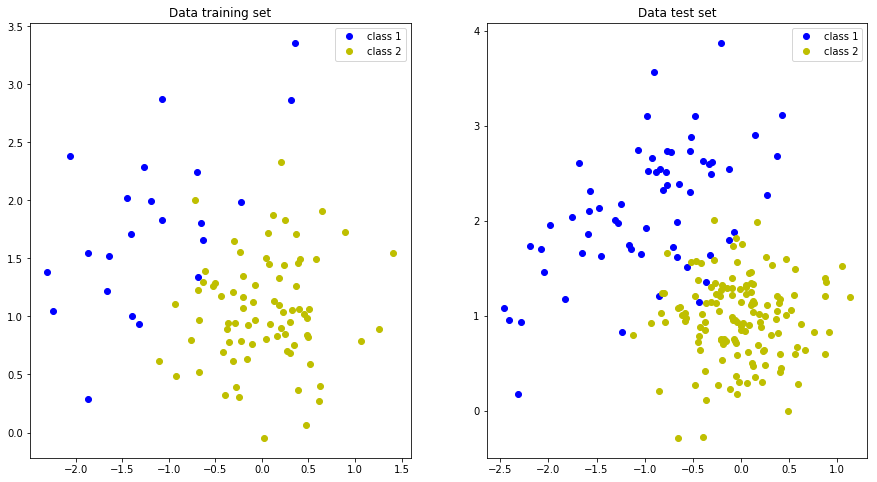

In [74]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


plt.subplot(121)
afficher_inference(x_train,class_train,true_labels=None, title = "Data training set",)

plt.subplot(122)
afficher_inference(x_test,class_test,true_labels=None, title = "Data test set",)

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [75]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1


### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


Trainig set
error rate : 3.0 %
Test set
error rate : 6.0 %


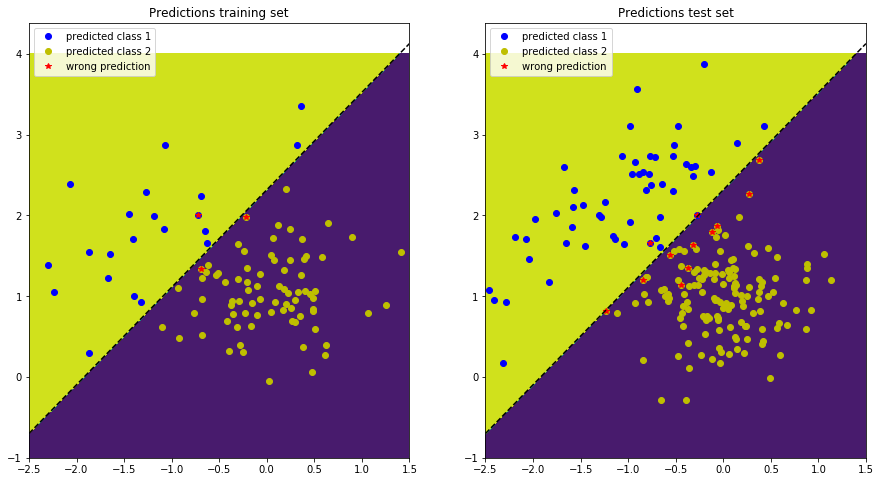

In [76]:
#Exercise 1
LR = Logistic_Regression()
LR.train(x_train, t)

plt.subplot(121)
print("Trainig set")
LR.plot_result(x_train, class_train,title="Predictions training set")
plot_DB_logistic(LR.w)

plt.subplot(122)
print("Test set")
LR.plot_result(x_test, class_test,title="Predictions test set")
plot_DB_logistic(LR.w)

A point X = (x,y) is in the decision boundary if <br>
    $sigmoid(X,w) = 0.5 <=> Xw = 0 , <=> $ y = - $\frac{w_0 + w_1 x }{w_2} $

#### Robustness to outliers

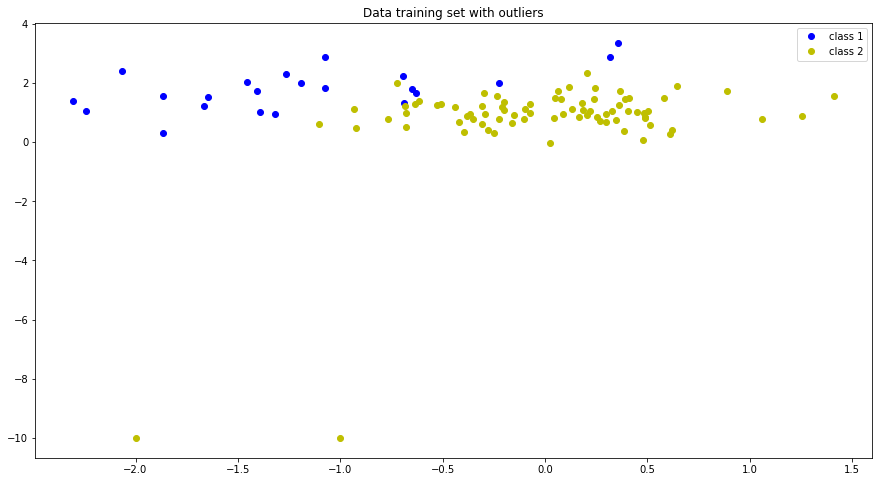

In [77]:
## Construct new data with outliers

# Outliers: 1st column is class, 2nd and 3rd are features
synth_outliers = np.array([[2, -2, -10],
                            [2, -1,-10]]) 

# Training set with outliers
synth_train_outliers = np.concatenate((synth_train,synth_outliers))

class_train_outliers = synth_train_outliers[:,0]
x_train_outliers = synth_train_outliers[:,1:]

t_outliers = 2-class_train_outliers   # 0 if class=2, 1 if class=1


N_train_outliers = np.size(x_train_outliers,axis=0)

X_outliers = add_feature["one"](x_train_outliers)
#X_outliers = np.hstack((np.ones((N_train_outliers,1)),x_train_outliers))
t_outliers = 2-class_train_outliers   # 0 if class=2, 1 if class=1

afficher_inference(x_train_outliers,class_train_outliers,title="Data training set with outliers")

In [78]:
##Logistic regression
#no outliers
w, Niter = regression_logistique(X, t,Nitermax=50, eps_conv=1e-3)
prediction_train = logistic_decision (X,w)
#with outliers
w_outliers, Niter = regression_logistique(X_outliers, t_outliers,Nitermax=50, eps_conv=1e-3)
prediction_train_outliers= logistic_decision (X_outliers,w_outliers)



## LDA 
#no outliers
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train,class_train)
LDA_prediction_train = LDA.predict(x_train)
#with outliers
LDA_outliers = LinearDiscriminantAnalysis()
LDA_outliers.fit(x_train_outliers,class_train_outliers)
LDA_prediction_train_outliers = LDA_outliers.predict(x_train_outliers)

Error rate training set Logistic regresion no outliers: 3.0 %
Error rate training set Logistic with outliers: 2.9411764705882355 %
Error rate training set LDA no outliers: 3.0 %
Error rate training set LDA with outliers: 8.823529411764707 %


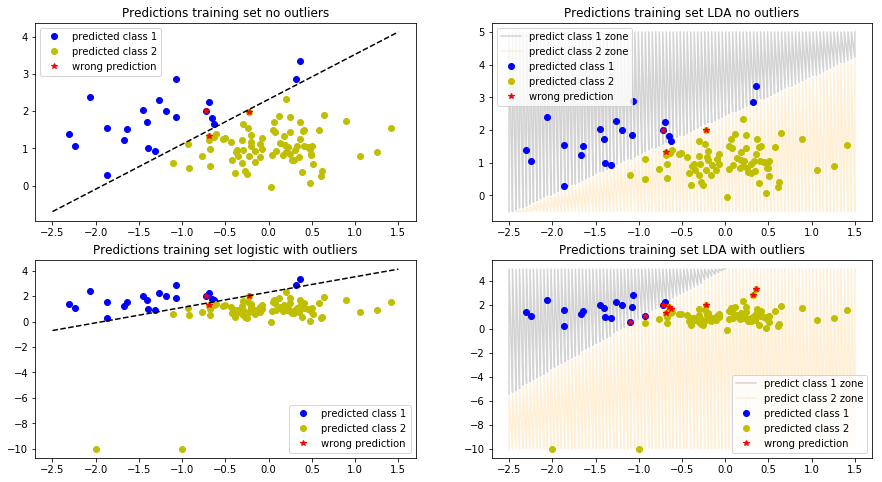

In [79]:
##Logistic regresion 
#no outliers
print("Error rate training set Logistic regresion no outliers:", erreur(prediction_train,class_train),"%")
plt.subplot(221)
afficher_inference (x_train,prediction_train,title = "Predictions training set no outliers",
                    true_labels = class_train)
plot_DB_logistic(w)

#with outliers
print("Error rate training set Logistic with outliers:",erreur(prediction_train_outliers,class_train_outliers),"%")
plt.subplot(223)
afficher_inference (x_train_outliers,prediction_train_outliers,
                    title = "Predictions training set logistic with outliers", true_labels = class_train_outliers)
plot_DB_logistic(w_outliers)


##LDA 
#no outliers
print("Error rate training set LDA no outliers:",erreur(LDA_prediction_train,class_train),"%")
plt.subplot(222)
plot_prediction_zones_LDA(LDA,x2min =-0.5, x2max=5)#plot predictions zones (ie decision boundaries)
afficher_inference (x_train,LDA_prediction_train,
                    title ="Predictions training set LDA no outliers", true_labels = class_train)

#with outliers
print("Error rate training set LDA with outliers:",erreur(LDA_prediction_train_outliers,class_train_outliers),"%")
plt.subplot(224)
plot_prediction_zones_LDA(LDA_outliers)#plot predictions zones
afficher_inference (x_train_outliers,LDA_prediction_train_outliers,
                    title = "Predictions training set LDA with outliers", true_labels = class_train_outliers)

#### Adding quadratic features

error rate : 3.0 %
error rate : 5.5 %


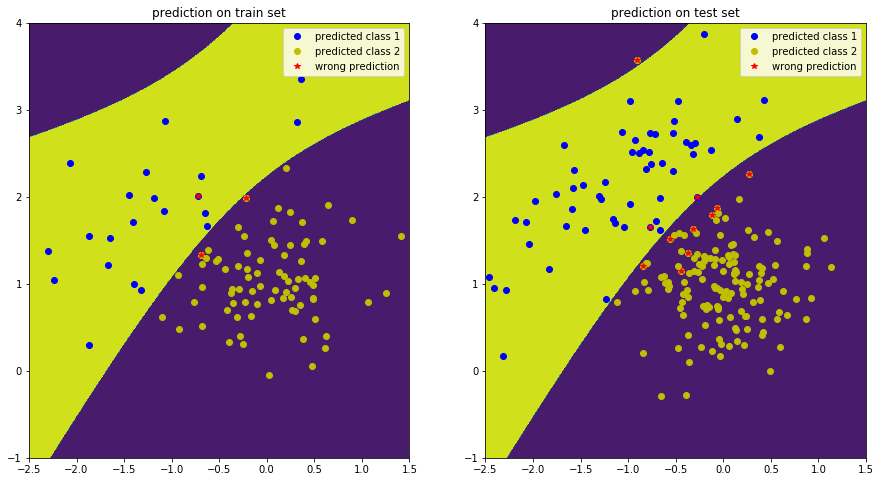

In [80]:
LRq = Logistic_Regression(add_feature="quadratic")
LRq.train(x_train, t)
subplot(121)
LRq.plot_result(x_train, class_train,title="prediction on train set")
subplot(122)
LRq.plot_result(x_test, class_test,title="prediction on test set")

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [81]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


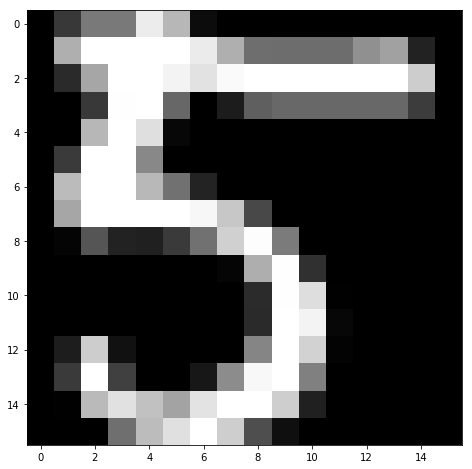

In [82]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

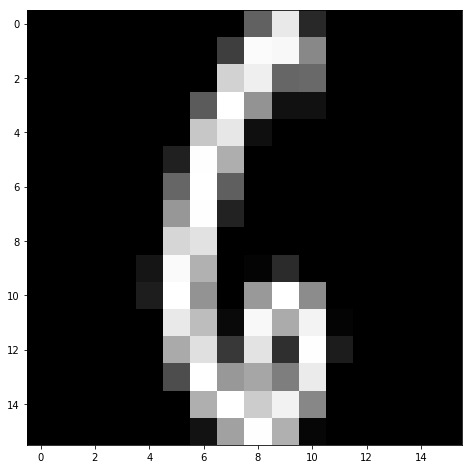

In [83]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [84]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 2      # label 2 for digit 5, it allow to use function from part one

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((N_test,1))
class_test[:556-145] = 2

t_train = class_train != 2 

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [85]:
# Exercise 2
np.min(I),np.max(I)

(-1.0, 1.0)

Text(0.5,1,'Standart deviation of pixels')

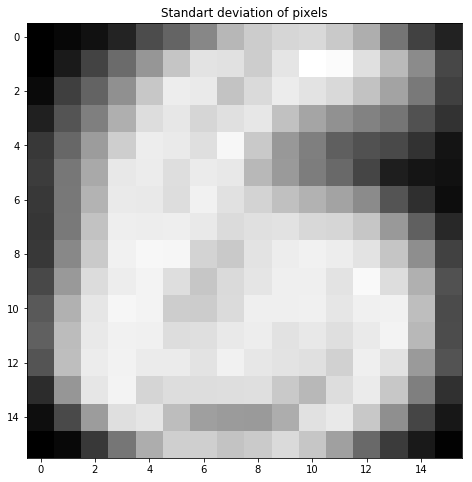

In [86]:
std = x_train_brut.std(axis=0).reshape((16,16)) # compute the standart deviation of each pixel
imshow(std,cmap='gray')
title("Standart deviation of pixels")

there are 173 significant pixels


Text(0.5,1,'Significants pixels')

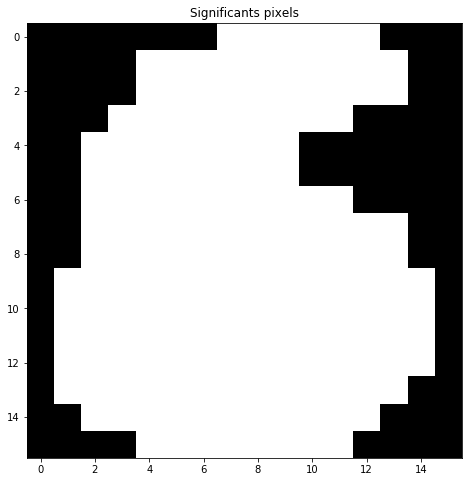

In [100]:
is_significant = x_train_brut.std(axis=0)>0.5 # pixels with standart deviation greater than 0.5
print(f"there are { is_significant.sum()} significant pixels")


imshow(is_significant.reshape((16,16)),cmap='gray')
title("Significants pixels")

In [101]:
x_train.shape

(345, 0)

In [102]:
# We extract the significant features of the training set
x_train = x_train_brut[:,is_significant]
# and of the test set
x_test = x_test_brut[:,is_significant]

In [107]:
LR = Logistic_Regression()
LR.train(x_train, t_train.reshape(-1), Niter=13)
print("Trainning set")
LR.error_rate(x_train, class_train.reshape(-1))
print("Test set")
LR.error_rate(x_test, class_test.reshape(-1))

Trainning set
error rate : 0.0 %
Test set
error rate : 7.885714285714286 %


We have a very low error for the training set and a hight error for the test set, we may have overtrained our data.
Futhermore we have to many data: 375 in comparaison of the model's complexity : 173 parameters

### With less complexity

In [88]:
L = []
for r in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    is_significant = x_train_brut.std(axis=0)>r
    # We extract the significant features of the training set
    x_train = x_train_brut[:,is_significant]
    # and of the test set
    x_test = x_test_brut[:,is_significant]
    LR = Logistic_Regression()
    LR.train(x_train, t_train.reshape(-1), Niter=5)
    print(r)
    print("Trainning set")
    LR.error_rate(x_train, class_train.reshape(-1))
    print("Test set")
    LR.error_rate(x_test, class_test.reshape(-1))

0.2
Trainning set
error rate : 0.0 %
Test set
error rate : 9.142857142857142 %
0.3
Trainning set
error rate : 0.0 %
Test set
error rate : 7.2 %
0.4
Trainning set
error rate : 0.0 %
Test set
error rate : 8.0 %
0.5
Trainning set
error rate : 0.0 %
Test set
error rate : 6.9714285714285715 %
0.6
Trainning set
error rate : 0.0 %
Test set
error rate : 6.171428571428572 %
0.7
Trainning set
error rate : 0.0 %
Test set
error rate : 6.857142857142857 %
0.8
Trainning set
error rate : 0.0 %
Test set
error rate : 9.142857142857142 %
0.9
Trainning set
error rate : 42.028985507246375 %
Test set
error rate : 46.97142857142857 %


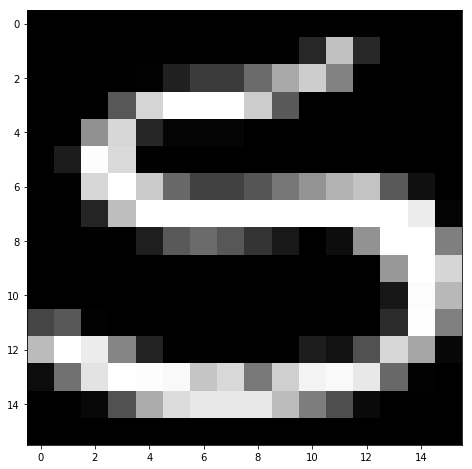

In [104]:
# misclassified image
misclassified = x_test_brut[LR.predict(x_test) != class_test.reshape(-1)]
n=40;
I = reshape(misclassified[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

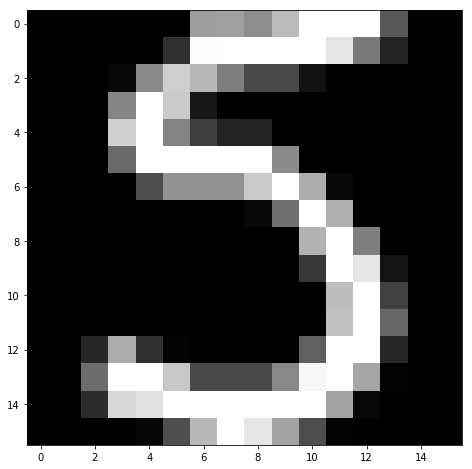

In [105]:
goodclassified = x_test_brut[LR.predict(x_test) == class_test.reshape(-1)]
n=40;
I = reshape(goodclassified[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
# Include your code here
from sklearn.linear_model import LogisticRegression
# ...


Commentaires :